***Deliver a pipeline with decision reports on the faults.***

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ultralytics/coco128")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'coco128' dataset.
Path to dataset files: /kaggle/input/coco128


--- Initializing Models on cpu ---
Processed 000000000349.jpg
Processed 000000000322.jpg
Processed 000000000446.jpg
Processed 000000000486.jpg
Processed 000000000597.jpg
Processed 000000000443.jpg
Processed 000000000387.jpg
Processed 000000000389.jpg


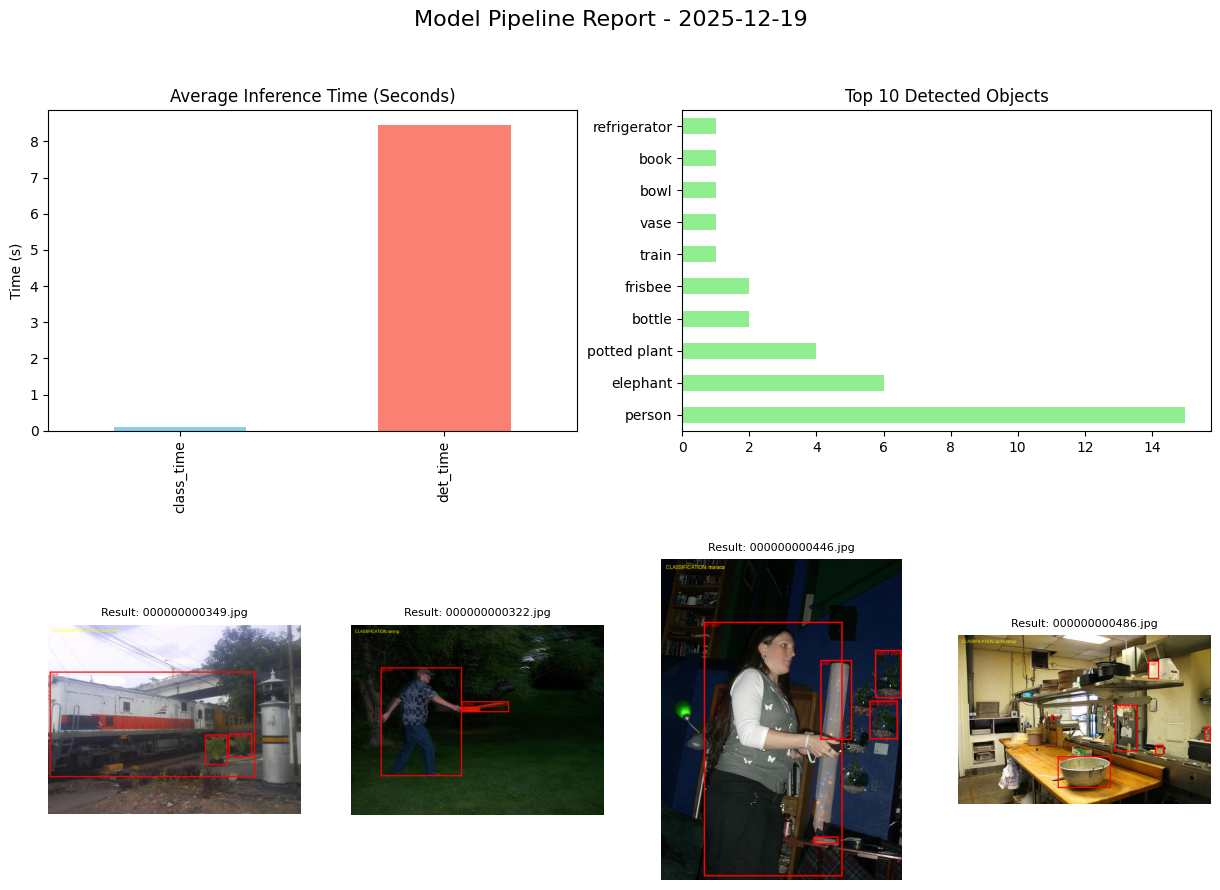

In [ ]:
import os
import time
import json
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from datetime import datetime
import torchvision.transforms as T
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

class SequentialModelController:
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"--- Initializing Models on {self.device} ---")

        # 1. Load Model A: Classification
        self.weights_a = ResNet18_Weights.DEFAULT
        self.model_a = resnet18(weights=self.weights_a).to(self.device)
        self.model_a.eval()
        self.categories_a = self.weights_a.meta["categories"]

        # 2. Load Model B: Detection
        self.weights_b = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
        self.model_b = fasterrcnn_resnet50_fpn(weights=self.weights_b).to(self.device)
        self.model_b.eval()
        self.categories_b = self.weights_b.meta["categories"]

        # Transforms
        self.transform_a = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(),
                                      T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        self.transform_b = T.ToTensor()

        self.results_log = []
        self.visualized_samples = []

    def run_inference(self, image_folder, limit=10):
        image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:limit]

        for filename in image_files:
            img_path = os.path.join(image_folder, filename)
            raw_img = Image.open(img_path).convert('RGB')

            # --- Model A: Classification ---
            input_a = self.transform_a(raw_img).unsqueeze(0).to(self.device)
            start_a = time.time()
            with torch.no_grad():
                preds_a = self.model_a(input_a)
                label_a = self.categories_a[torch.argmax(preds_a, dim=1).item()]
            time_a = time.time() - start_a

            # --- Model B: Detection ---
            input_b = [self.transform_b(raw_img).to(self.device)]
            start_b = time.time()
            with torch.no_grad():
                preds_b = self.model_b(input_b)
                # Filter high confidence (score > 0.8)
                scores = preds_b[0]['scores'].cpu().numpy()
                boxes = preds_b[0]['boxes'].cpu().numpy()
                labels = preds_b[0]['labels'].cpu().numpy()

                keep = scores > 0.8
                final_boxes = boxes[keep]
                final_labels = [self.categories_b[i] for i in labels[keep]]
            time_b = time.time() - start_b

            # Log results
            self.results_log.append({
                "filename": filename,
                "class_label": label_a,
                "class_time": time_a,
                "det_objects": final_labels,
                "det_time": time_b,
                "total_time": time_a + time_b
            })

            # Store visualization data for a few samples
            self.create_visual_overlay(raw_img, final_boxes, final_labels, label_a, filename)
            print(f"Processed {filename}")

    def create_visual_overlay(self, img, boxes, labels, class_label, filename):
        """Draws boxes and labels on the image."""
        draw = ImageDraw.Draw(img)
        # Draw Detections
        for box, label in zip(boxes, labels):
            draw.rectangle(list(box), outline="red", width=3)
            draw.text((box[0], box[1]), label, fill="red")

        # Draw Overall Classification Label
        draw.text((10, 10), f"CLASSIFICATION: {class_label}", fill="yellow")

        # Save to list for final plot
        self.visualized_samples.append((img, filename))

    def generate_visual_report(self):
        df = pd.DataFrame(self.results_log)

        # Set up a multi-plot figure
        fig = plt.figure(figsize=(15, 10))
        plt.subplots_adjust(hspace=0.4)

        # 1. Plot Timing Comparison
        ax1 = fig.add_subplot(2, 2, 1)
        df[['class_time', 'det_time']].mean().plot(kind='bar', ax=ax1, color=['skyblue', 'salmon'])
        ax1.set_title("Average Inference Time (Seconds)")
        ax1.set_ylabel("Time (s)")

        # 2. Plot Detection Frequency
        ax2 = fig.add_subplot(2, 2, 2)
        all_objects = [obj for sublist in df['det_objects'] for obj in sublist]
        if all_objects:
            pd.Series(all_objects).value_counts().head(10).plot(kind='barh', ax=ax2, color='lightgreen')
        ax2.set_title("Top 10 Detected Objects")

        # 3. Show Visualized Images (Sample Grid)
        for i, (img, name) in enumerate(self.visualized_samples[:4]):
            ax = fig.add_subplot(2, 4, 5 + i)
            ax.imshow(img)
            ax.set_title(f"Result: {name}", fontsize=8)
            ax.axis('off')

        plt.suptitle(f"Model Pipeline Report - {datetime.now().strftime('%Y-%m-%d')}", fontsize=16)
        plt.savefig("pipeline_visualization.png")
        plt.show()

# --- RUN ON KAGGLE ---
if __name__ == "__main__":
    # COCO128 Path on Kaggle
    DATA_PATH = "/kaggle/input/coco128/coco128/images/train2017"

    # If path doesn't exist (local testing), use a dummy
    if not os.path.exists(DATA_PATH):
        print("Dataset not found. Please ensure COCO128 is added.")
    else:
        controller = SequentialModelController()
        controller.run_inference(DATA_PATH, limit=8)
        controller.generate_visual_report()

        # Save CSV
        pd.DataFrame(controller.results_log).to_csv("combined_results.csv", index=False)

***Build a controller that runs Model A (classification) then Model B (detection) sequentially on the same image set, with logged timing and a combined report.***

In [1]:
import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.detection import ssdlite320_mobilenet_v3_large, SSDLite320_MobileNet_V3_Large_Weights
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
import time
import pandas as pd
import os
from tqdm import tqdm

# 1. SETUP MODELS
class PipelineController:
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        # Model A: Classification (ResNet18)
        self.model_a = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.model_a.to(self.device).eval()

        # Model B: Detection (SSD Lite)
        self.model_b = ssdlite320_mobilenet_v3_large(weights=SSDLite320_MobileNet_V3_Large_Weights.DEFAULT)
        self.model_b.to(self.device).eval()

        # Transforms
        self.transform_a = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.transform_b = T.Compose([
            T.ToTensor()
        ])

        self.logs = []

    def run_pipeline(self, image_path):
        img_name = os.path.basename(image_path)
        raw_img = Image.open(image_path).convert("RGB")

        results = {"filename": img_name}

        # --- STEP A: CLASSIFICATION ---
        start_a = time.time()
        input_a = self.transform_a(raw_img).unsqueeze(0).to(self.device)

        with torch.no_grad():
            out_a = self.model_a(input_a)
            prob_a = torch.nn.functional.softmax(out_a[0], dim=0)
            conf_a, class_idx_a = torch.max(prob_a, 0)

        end_a = time.time()
        results["class_id"] = class_idx_a.item()
        results["class_conf"] = round(conf_a.item(), 4)
        results["time_classify_ms"] = round((end_a - start_a) * 1000, 2)

        # --- STEP B: DETECTION ---
        start_b = time.time()
        input_b = self.transform_b(raw_img).unsqueeze(0).to(self.device)

        with torch.no_grad():
            out_b = self.model_b(input_b)
            # Filter detections with confidence > 0.5
            boxes = out_b[0]['boxes'][out_b[0]['scores'] > 0.5]

        end_b = time.time()
        results["objects_detected"] = len(boxes)
        results["time_detect_ms"] = round((end_b - start_b) * 1000, 2)
        results["total_time_ms"] = results["time_classify_ms"] + results["time_detect_ms"]

        self.logs.append(results)
        return results

    def get_report(self):
        df = pd.DataFrame(self.logs)
        summary = {
            "Total Images": len(df),
            "Avg Classify Time (ms)": df["time_classify_ms"].mean(),
            "Avg Detect Time (ms)": df["time_detect_ms"].mean(),
            "Total Processing Time (ms)": df["total_time_ms"].sum()
        }
        return df, summary

# 2. DOWNLOAD DATASET (Oxford-IIIT Pet)
# Kaggle/Torchvision will download this to the working directory
dataset = torchvision.datasets.OxfordIIITPet(
    root='./data',
    download=True,
    split='test'
)

# 3. EXECUTION
controller = PipelineController()

# Process first 50 images for the demo
print("Starting Sequential Inference...")
image_paths = [dataset._images[i] for i in range(50)]

for path in tqdm(image_paths):
    controller.run_pipeline(path)

# 4. GENERATE REPORT
report_df, summary = controller.get_report()

print("\n--- Summary Report ---")
for key, value in summary.items():
    print(f"{key}: {value:.2f}")

print("\n--- Detailed Logs (First 5 Rows) ---")
print(report_df.head())

# Save to CSV for Kaggle Output
report_df.to_csv("inference_report.csv", index=False)

100%|██████████| 792M/792M [00:18<00:00, 43.7MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 18.9MB/s]


Using device: cpu
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


Downloading: "https://download.pytorch.org/models/ssdlite320_mobilenet_v3_large_coco-a79551df.pth" to /root/.cache/torch/hub/checkpoints/ssdlite320_mobilenet_v3_large_coco-a79551df.pth


100%|██████████| 13.4M/13.4M [00:00<00:00, 129MB/s]


Starting Sequential Inference...


100%|██████████| 50/50 [00:09<00:00,  5.19it/s]


--- Summary Report ---
Total Images: 50.00
Avg Classify Time (ms): 93.86
Avg Detect Time (ms): 93.09
Total Processing Time (ms): 9347.36

--- Detailed Logs (First 5 Rows) ---
             filename  class_id  class_conf  time_classify_ms  \
0  Abyssinian_201.jpg       285      0.3199            116.14   
1  Abyssinian_202.jpg       285      0.5922             79.84   
2  Abyssinian_204.jpg       285      0.5142             77.86   
3  Abyssinian_205.jpg       191      0.1236             82.11   
4  Abyssinian_206.jpg       285      0.8107             84.01   

   objects_detected  time_detect_ms  total_time_ms  
0                 1          146.99         263.13  
1                 1           79.87         159.71  
2                 1           76.05         153.91  
3                 1          102.10         184.21  
4                 1           70.23         154.24  


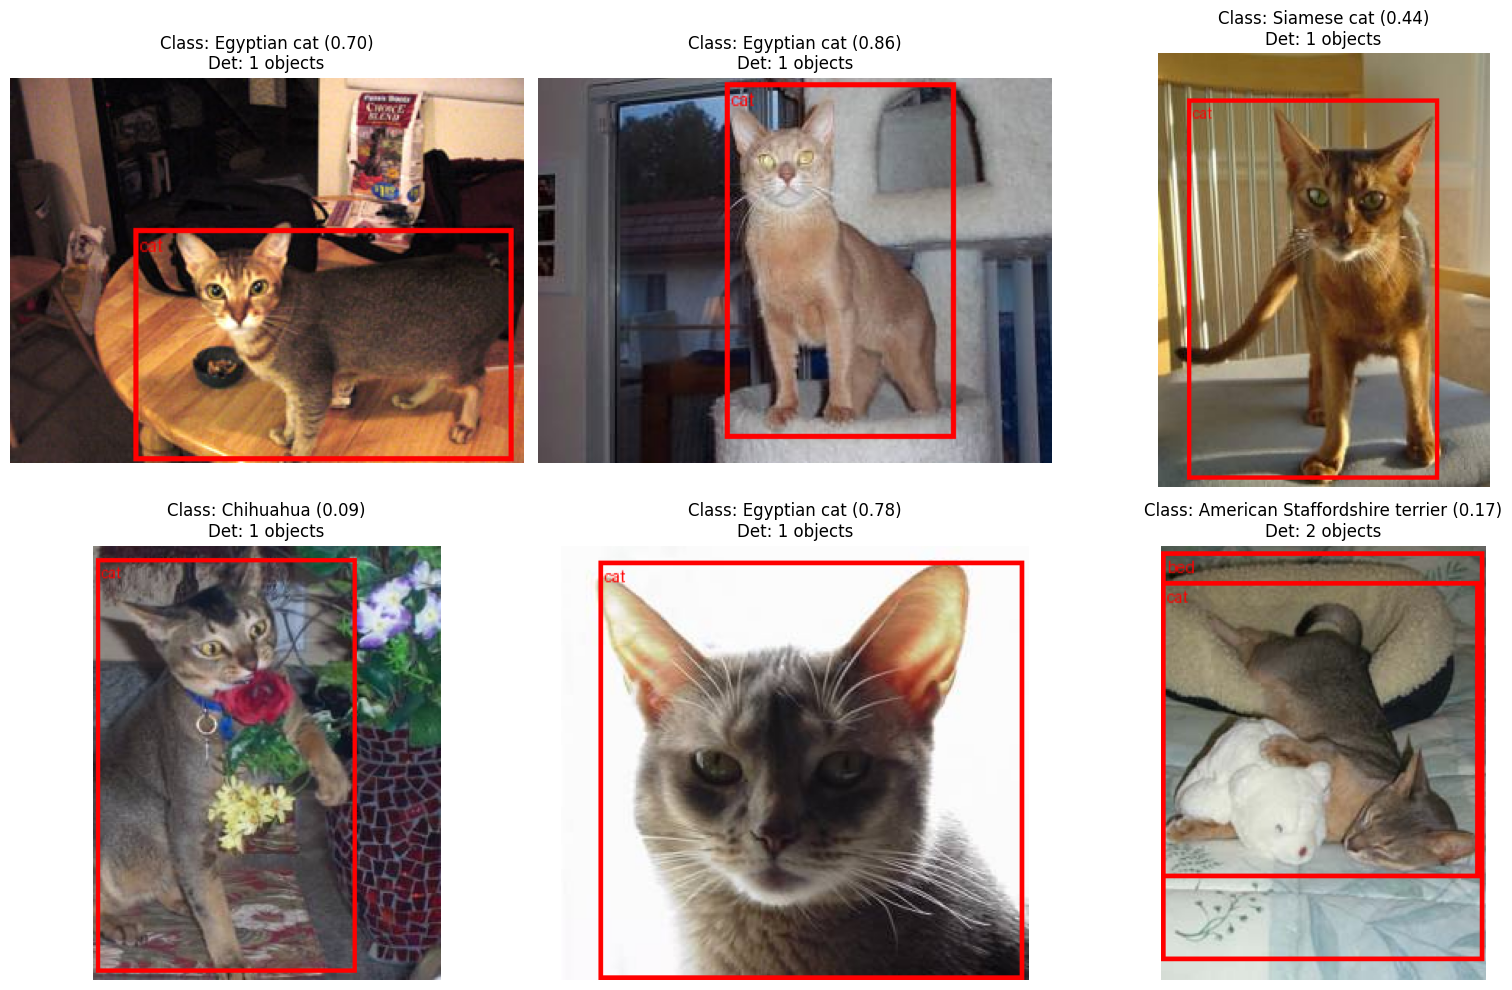

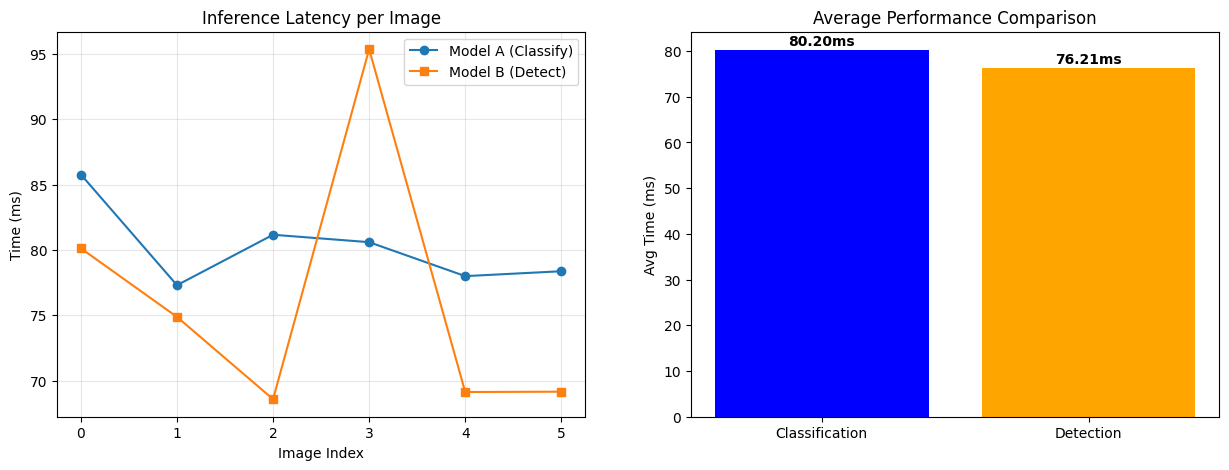


PIPELINE SUMMARY REPORT
Total Images Processed: 6
Avg Classification Time: 80.20 ms
Avg Detection Time:      76.21 ms
Average Total Pipeline:  156.41 ms


In [2]:
import torch
import torchvision
import torchvision.transforms as T
from torchvision.utils import draw_bounding_boxes
from torchvision.models.detection import ssdlite320_mobilenet_v3_large, SSDLite320_MobileNet_V3_Large_Weights
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import os
from PIL import Image

# 1. SETUP CONTROLLER
class VisualPipelineController:
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Model A: Classification
        self.weights_a = ResNet18_Weights.DEFAULT
        self.model_a = resnet18(weights=self.weights_a).to(self.device).eval()
        self.categories_a = self.weights_a.meta["categories"]

        # Model B: Detection
        self.weights_b = SSDLite320_MobileNet_V3_Large_Weights.DEFAULT
        self.model_b = ssdlite320_mobilenet_v3_large(weights=self.weights_b).to(self.device).eval()
        self.categories_b = self.weights_b.meta["categories"]

        self.transform_a = self.weights_a.transforms()
        self.logs = []

    def run_inference(self, img_path):
        # Load image
        img_raw = Image.open(img_path).convert("RGB")
        img_tensor = T.ToTensor()(img_raw) # For drawing
        img_int = (img_tensor * 255).type(torch.uint8)

        # --- STEP A: CLASSIFICATION ---
        start_a = time.time()
        input_a = self.transform_a(img_raw).unsqueeze(0).to(self.device)
        with torch.no_grad():
            pred_a = self.model_a(input_a).softmax(1)
            conf_a, idx_a = torch.max(pred_a, 1)
        time_a = (time.time() - start_a) * 1000

        # --- STEP B: DETECTION ---
        start_b = time.time()
        input_b = [img_tensor.to(self.device)]
        with torch.no_grad():
            pred_b = self.model_b(input_b)[0]
        time_b = (time.time() - start_b) * 1000

        # Filter high confidence detections
        mask = pred_b['scores'] > 0.5
        boxes = pred_b['boxes'][mask]
        labels = [self.categories_b[i] for i in pred_b['labels'][mask]]

        # Log results
        res = {
            "class": self.categories_a[idx_a.item()],
            "class_conf": conf_a.item(),
            "boxes": boxes.cpu(),
            "labels": labels,
            "time_a": time_a,
            "time_b": time_b,
            "img_display": img_int
        }
        self.logs.append(res)
        return res

# 2. LOAD DATASET
dataset = torchvision.datasets.OxfordIIITPet(root='./data', download=True, split='test')
controller = VisualPipelineController()

# 3. RUN PIPELINE ON SAMPLE
num_samples = 6
for i in range(num_samples):
    img_path = dataset._images[i]
    controller.run_inference(img_path)

# 4. VISUALIZATION - IMAGES & BOXES
plt.figure(figsize=(16, 10))
for i in range(num_samples):
    res = controller.logs[i]

    # Draw boxes on image
    annotated_img = res['img_display']
    if len(res['boxes']) > 0:
        annotated_img = draw_bounding_boxes(res['img_display'], res['boxes'],
                                            labels=res['labels'], colors="red", width=3)

    plt.subplot(2, 3, i+1)
    plt.imshow(annotated_img.permute(1, 2, 0))
    plt.title(f"Class: {res['class']} ({res['class_conf']:.2f})\nDet: {len(res['labels'])} objects")
    plt.axis('off')

plt.tight_layout()
plt.show()

# 5. VISUALIZATION - PERFORMANCE GRAPHS
df = pd.DataFrame(controller.logs).drop(columns=['img_display', 'boxes'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Latency per Image
ax1.plot(df.index, df['time_a'], label='Model A (Classify)', marker='o')
ax1.plot(df.index, df['time_b'], label='Model B (Detect)', marker='s')
ax1.set_xlabel('Image Index')
ax1.set_ylabel('Time (ms)')
ax1.set_title('Inference Latency per Image')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Average Execution Time Breakdown
avg_times = [df['time_a'].mean(), df['time_b'].mean()]
ax2.bar(['Classification', 'Detection'], avg_times, color=['blue', 'orange'])
ax2.set_ylabel('Avg Time (ms)')
ax2.set_title('Average Performance Comparison')
for i, v in enumerate(avg_times):
    ax2.text(i, v + 1, f"{v:.2f}ms", ha='center', fontweight='bold')

plt.show()

# Final Summary Report
print("\n" + "="*30)
print("PIPELINE SUMMARY REPORT")
print("="*30)
print(f"Total Images Processed: {len(df)}")
print(f"Avg Classification Time: {df['time_a'].mean():.2f} ms")
print(f"Avg Detection Time:      {df['time_b'].mean():.2f} ms")
print(f"Average Total Pipeline:  {(df['time_a'] + df['time_b']).mean():.2f} ms")
print("="*30)